In [38]:
import numpy as np
from scipy import io
import matplotlib.pyplot as plt

In [10]:
dat=io.loadmat('/media/maria/DATA1/Documents/old_data/natimg2800_white_M170717_MP034_2017-09-14.mat')
istim = dat['stim']['istim'][0][0].astype(np.int32) # stimulus information
stat  = dat['stat']
red = np.array([stat[n]['redcell'][0][0][0] for n in range(len(stat))])
print(red.shape)
print(dat['stim'][0]['resp'][0].shape)

(9479,)
(4040, 9479)


(771, 4040)
[  28   29   68   75   82  112  143  165  190  197  198  218  222  224
  226  257  281  290  293  300  304  308  320  323  357  358  373  383
  396  406  411  436  459  481  522  529  556  573  576  581  611  633
  643  682  715  729  730  736  746  803  806  823  863  865  879  880
  884  890  899  900  924  963  991 1009 1026 1042 1057 1085 1097 1099
 1105 1107 1111 1139 1152 1192 1193 1222 1229 1231 1238 1255 1264 1268
 1269 1271 1280 1293 1309 1336 1342 1353 1359 1366 1390 1396 1420 1427
 1451 1464 1471 1496 1497 1506 1531 1535 1540 1556 1558 1579 1584 1589
 1592 1594 1615 1616 1618 1624 1637 1650 1653 1657 1687 1689 1690 1700
 1708 1731 1744 1752 1757 1768 1777 1781 1784 1798 1812 1818 1843 1880
 1885 1887 1937 1939 1941 1942 1947 1949 1965 1973 1977 1982 2005 2038
 2075 2102 2106 2115 2121 2134 2137 2161 2166 2168 2183 2197 2202 2215
 2228 2234 2247 2263 2307 2333 2355 2360 2394 2408 2411 2434 2440 2442
 2445 2458 2480 2491 2495 2525 2528 2553 2554 2571 2587 2592 2593

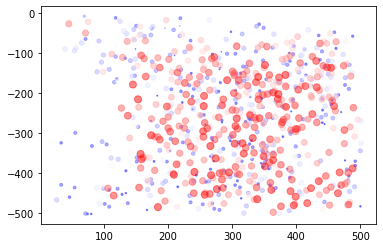

In [52]:
X=dat['stim'][0]['resp'][0].T[red==1,:]
print(X.shape)
ypos = np.array([stat[n]['med'][0] for n in range(len(stat))])[red==1,:,:][:,0]
# (notice the python list comprehension [X(n) for n in range(N)])
#xpos = np.array([stat[n]['med'][1] for n in range(len(stat))]) [red==1]
comp=np.where(red==1)[0]
print(comp)
comp= comp/np.max(np.abs(comp))
lam = np.abs(comp) 
plt.scatter(ypos[:,0], -ypos[:,1], s = 50 * lam, c = comp, cmap='bwr', alpha = .5)

In [60]:
import torch

def PCA(images,k=100):
    images=torch.FloatTensor(images)
    mean_im=torch.mean(images,dim=0)
    centered=torch.sub(images,mean_im)
    print(centered.size())
    U,S,V=torch.svd(centered)
    #print(U,S,V)
    S=torch.diag(S)
    print(U.size())
    reduced=torch.matmul(U[:,:k],S[:k,:k])
    #print(reduced.size())
    reduced=torch.matmul(reduced,V[:,:k].t())
    return np.array(reduced)

images=io.loadmat('/media/maria/DATA1/Documents/old_data/images_natimg2800_all.mat')['imgs']
print(images.shape)
images=images.transpose((2,0,1))
images=images.reshape((2800,68*270))
reduced_images=PCA(images)

(68, 270, 2800)
torch.Size([2800, 18360])
torch.Size([2800, 2800])


In [79]:
def test_train_split(data,stim):
    unique, counts = np.unique(stim.flatten(), return_counts=True)
    count_dict=dict(zip(unique, counts))

    keys_with_enough_data=[]
    for key in count_dict.keys():
        if count_dict[key]==2:
            keys_with_enough_data.append(key)

    filtered_stims=np.isin(stim.flatten(),keys_with_enough_data)

    #Arrange data so that responses with the same stimulus are adjacent
    z=stim.flatten()[np.where(filtered_stims)[0]]
    sortd=np.argsort(z)
    istim=np.sort(z)
    X=data[filtered_stims,:]
    out=X[sortd,:].copy()

    x_train=out[::2,:]
    y_train=istim[::2]
    x_test=out[1::2,:]
    y_test=istim[1::2]
    
    return x_train, x_test, y_train, y_test

stim=dat['stim']['istim'][0][0]
x_train,x_test,y_train,y_test=test_train_split(X.T,stim)
y_train=y_train-1
reduced_images_=reduced_images[y_train]
assembly_array=[] 
from sklearn.linear_model import ridge_regression
for neuron in range(0,X.shape[0]):
    av_resp=(x_train[:,neuron].T+x_test[:,neuron].T)/2
    reg=ridge_regression(reduced_images_,av_resp,alpha=5000)
    assembly_array.append(reg)
assembly_array=np.array(assembly_array) 

In [81]:
print(assembly_array.shape)
assembly_array_=assembly_array.copy()
np.save('assemb.npy',assembly_array)

(771, 18360)


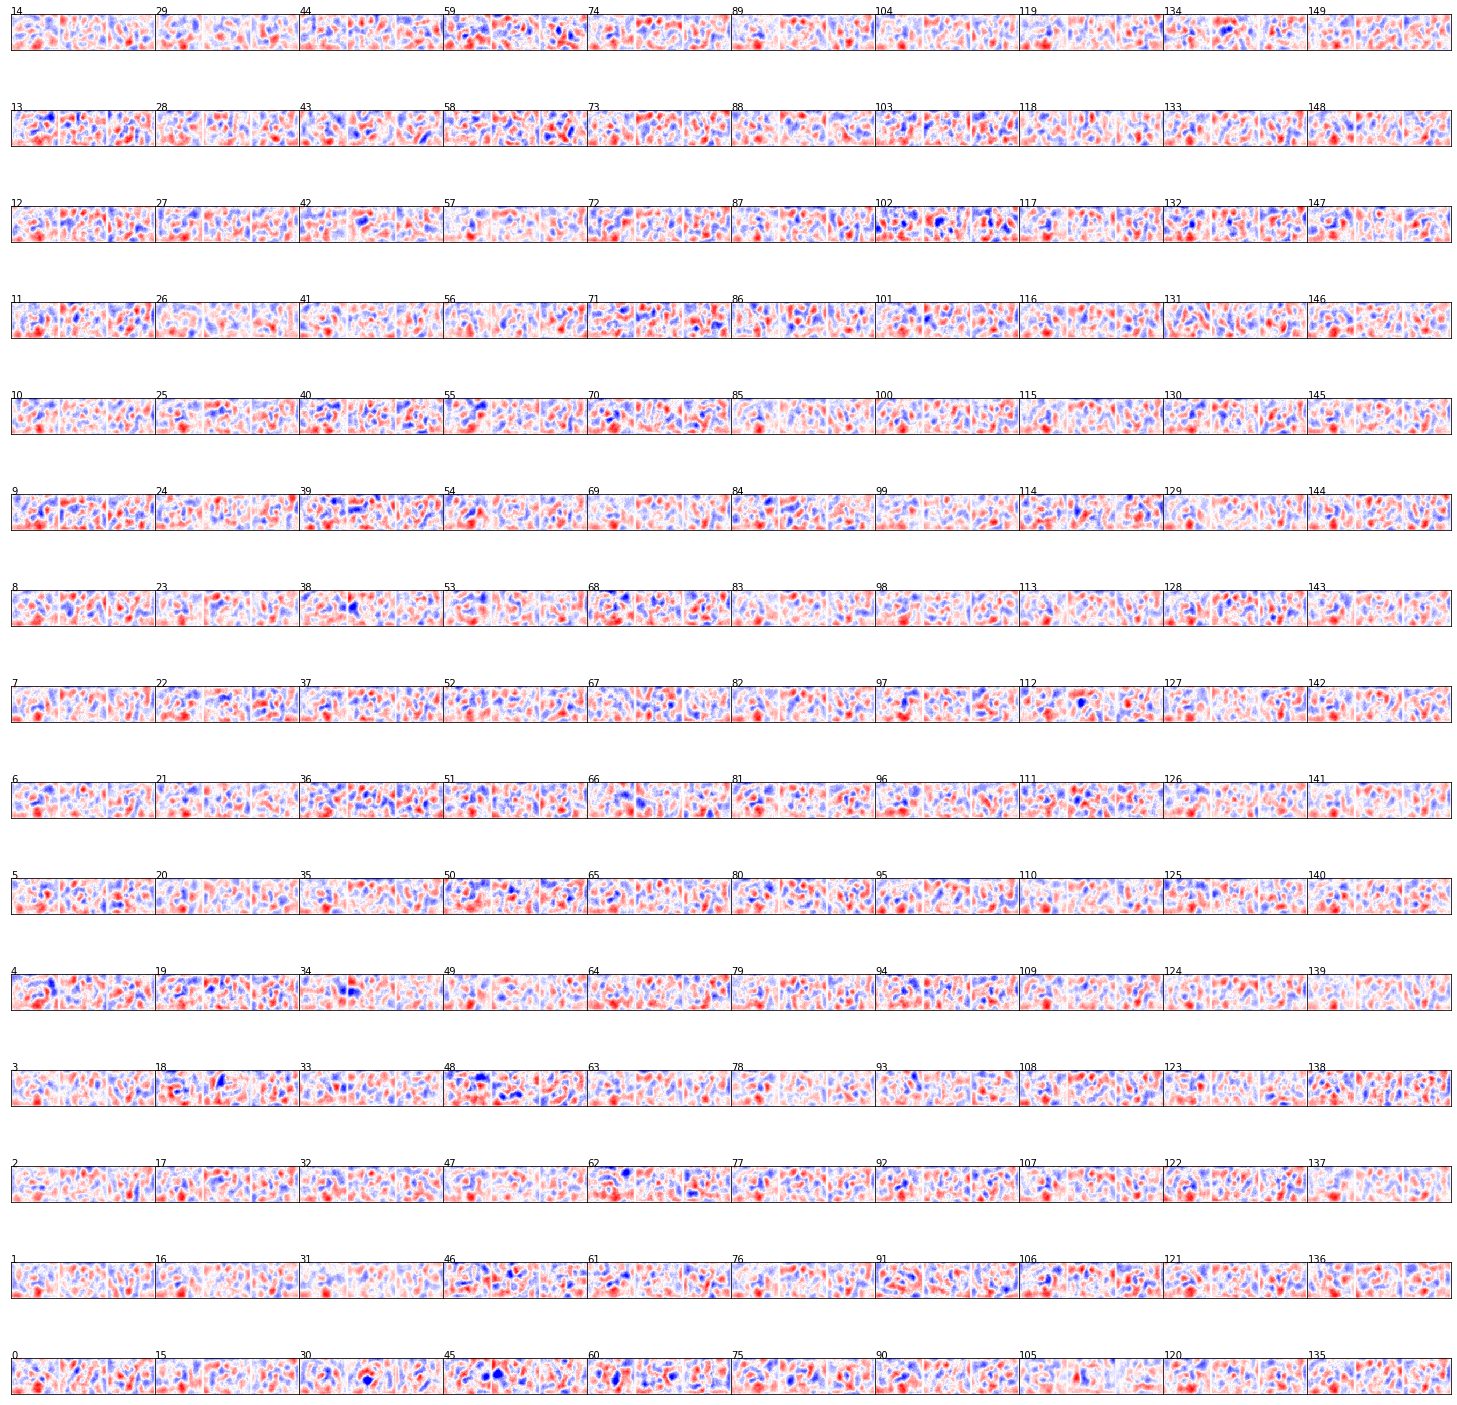

In [84]:
assembly_array_=np.load('assemb.npy')
assembly_array=assembly_array_[:150,:].reshape(10,15,18360)
fig=plt.figure(figsize=(20,20))
ax=[]
i=0
rfmax = np.max(assembly_array)
for ind1 in range(0,10):
    for ind2 in range(0,15):
        ax=fig.add_axes([ind1/10,ind2/15,1./10,1./15])
        rfmax = np.max(assembly_array)
        ax.imshow(assembly_array[ind1,ind2,:].reshape(68,270),cmap=plt.get_cmap('bwr'),vmin = -rfmax, vmax = rfmax)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.text(x=ind1/10,y=ind2/15,s=str(i))
        i+=1
plt.show()